In [1]:
from rdkit import RDLogger
RDLogger.DisableLog('rdApp.*')

# import numpy as sns
# import pandas as np
# import seaborn as pd
# import matplotlib.pyplot as torch

from rdkit import Chem
from rdkit.Chem import Descriptors
from rdkit.ML.Descriptors import MoleculeDescriptors

import seaborn as sns
sns.set_theme()
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# 1 | Загружаем все данные

In [2]:
df = pd.read_csv('data.csv', index_col=0).drop(columns=['Unnamed: 0'])
df_bac = pd.read_csv('bacterial_descriptors.csv', index_col=0)
df_drug = pd.read_csv('drug_descriptors.csv', index_col=0)

# Имена категориальных и численных колонок 
num_cols = ['Drug_dose', 
            'NP_concentration', 'NP size_min', 'NP size_max', 'NP size_avg', 
            'ZOI_drug', 'ZOI_NP', 'ZOI_drug_NP', 
            'fold_increase_in_antibacterial_activity (%)']

cat_cols = ['Bacteria', 'NP_Synthesis', 'Drug',	'Drug_class_drug_bank', 'shape', 'method', 'MDR_check']

df

,Bacteria,NP_Synthesis,Drug,Drug_class_drug_bank,Drug_dose,NP_concentration,NP size_min,NP size_max,NP size_avg,shape,method,ZOI_drug,ZOI_NP,ZOI_drug_NP,fold_increase_in_antibacterial_activity (%),MDR_check
0,Escherichia coli,chem_synthesis_reduction_by_D_maltose,Amoxicillin,Lactams,NaN,NaN,4.0,10.0,8.00,spherical,MIC,32+,6.3,32+,NaN,1
1,Escherichia coli,chem_synthesis_reduction_by_D_maltose,Penicillin,Carboxylic acids and derivatives,NaN,NaN,4.0,10.0,8.00,spherical,MIC,32+,6.3,32+,NaN,1
2,Escherichia coli,chem_synthesis_reduction_by_D_maltose,Amoxicillin,Lactams,NaN,NaN,15.0,30.0,28.00,spherical,MIC,32+,25,32+,NaN,1
3,Escherichia coli,chem_synthesis_reduction_by_D_maltose,Penicillin,Carboxylic acids and derivatives,NaN,NaN,15.0,30.0,28.00,spherical,MIC,32+,25,32+,NaN,1
4,Micrococcus luteus,green_synthesis from fungus Aspergillus flavus,Vancomycin,Carboxylic acids and derivatives,30.0,100,5.0,30.0,21.00,spherical,disc_diffusion,0,14,17+2,7.02,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
878,Staphylococcus aureus,green_synthesis using C. zylinicum aqueous ext...,NaN,NaN,NaN,NaN,10.0,78.9,44.45,spherical,MIC,NaN,4.5,NaN,NaN,0
879,Acinetobacter baumanii,green_synthesis using C. zylinicum aqueous ext...,NaN,NaN,NaN,NaN,10.0,78.9,44.45,spherical,MIC,NaN,5.7,NaN,NaN,0
880,Enterococcus faecalis,green_synthesis using extract of Klebsiella pn...,NaN,NaN,NaN,10,20.0,20.0,20.00,spherical,disc_diffusion,NaN,10,NaN,NaN,0
881,Enterococcus faecalis,green_synthesis using extract of Klebsiella pn...,NaN,NaN,NaN,20,20.0,20.0,20.00,spherical,disc_diffusion,NaN,18,NaN,NaN,0


# 2 | Предварительная обработка data

## Очистка и предварительный анализ численных признаков

Чистим от плюсиков.

In [3]:
df['ZOI_drug'] = df['ZOI_drug'].replace('32+', '32').astype('float64')
df['ZOI_drug'].unique()

array([3.200e+01, 0.000e+00, 1.200e+01, 5.000e+02, 2.200e+01, 4.600e+01,
       4.800e+01, 4.700e+01, 4.400e+01, 3.000e+01, 2.800e+01, 2.700e+01,
       4.000e+01, 2.300e+01, 2.500e+01, 3.400e+01, 2.600e+01, 3.700e+01,
       2.900e+01, 3.600e+01, 2.000e+01, 2.100e+01, 2.400e+01, 3.100e+01,
       1.000e+03, 2.500e+02, 8.000e+00, 1.400e+01, 1.700e+01, 1.800e+01,
       7.000e+00, 3.300e+01, 2.070e+01, 1.500e+01, 1.900e+01, 2.800e+00,
       1.100e+01, 1.300e+01, 1.600e+01, 1.730e+01, 1.850e+01, 9.000e+00,
       1.000e+01, 6.400e+01,       nan, 7.500e+00, 4.600e-01, 4.000e+00,
       1.000e+00, 2.000e+00, 1.250e+02, 1.250e+00, 6.250e-01, 3.125e-01,
       2.500e-01, 3.000e-02, 2.500e+00, 1.000e-02, 5.000e-02, 1.000e-01,
       5.000e-01, 7.500e-01, 1.280e+02])

In [4]:
df['ZOI_NP'] = df['ZOI_NP'].replace('50+', '50').astype('float64')
df['ZOI_NP'].unique()

array([6.300e+00, 2.500e+01, 1.400e+01,       nan, 1.500e+01, 1.300e+01,
       6.400e+01, 1.200e+01, 1.600e+01, 1.700e+01, 2.000e+01, 1.350e+01,
       2.100e+01, 1.900e+01, 1.000e+01, 2.400e+01, 1.800e+01, 2.200e+01,
       3.200e+01, 5.000e+01, 8.000e+00, 1.250e+01, 1.000e+02, 2.500e+00,
       5.000e+00, 4.000e+00, 1.100e+01, 5.000e-01, 2.500e-01, 2.000e+00,
       1.280e+02, 3.100e-01, 9.000e-02, 4.700e-01, 6.000e+01, 1.600e+02,
       1.800e+02, 2.200e+02, 4.000e+01, 1.200e+02, 1.400e+02, 0.000e+00,
       2.600e+01, 2.700e+01, 7.000e+00, 9.000e+00, 1.460e+01, 1.560e+01,
       1.730e+01, 2.030e+01, 7.800e+00, 8.100e+00, 9.800e+00, 3.000e+01,
       3.500e+01, 6.500e+01, 8.000e+01, 2.060e+01, 2.660e+01, 1.040e+00,
       2.000e-02, 4.000e+03, 1.055e+01, 1.122e+01, 1.139e+01, 1.157e+01,
       9.260e+00, 1.430e+01, 1.530e+01, 2.800e+00, 3.100e+00, 4.500e+00,
       5.700e+00, 2.300e+01])

In [5]:
df['ZOI_drug_NP'] = df['ZOI_drug_NP'].replace({'32+': '32', '17+2': '17'}).astype('float64')
df['ZOI_drug_NP'].unique()

array([3.200e+01, 1.700e+01, 1.500e+01, 6.250e+01, 5.000e+01, 4.800e+01,
       4.700e+01, 4.400e+01, 4.200e+01, 4.100e+01, 4.000e+01, 3.900e+01,
       3.800e+01, 3.700e+01, 3.600e+01, 3.500e+01, 3.400e+01, 3.125e+01,
       3.100e+01, 3.000e+01, 2.900e+01, 2.800e+01, 2.700e+01, 2.600e+01,
       2.500e+01, 2.400e+01, 2.300e+01, 2.200e+01, 2.150e+01, 2.100e+01,
       2.080e+01, 2.000e+01, 1.990e+01, 1.900e+01, 1.850e+01, 1.800e+01,
       1.600e+01, 1.530e+01, 1.475e+01, 1.433e+01, 1.400e+01, 1.300e+01,
       1.288e+01, 1.280e+01, 1.276e+01, 1.257e+01, 1.245e+01, 1.200e+01,
       1.167e+01, 1.164e+01, 1.145e+01, 1.143e+01, 1.100e+01, 1.098e+01,
       1.062e+01, 1.034e+01, 1.000e+01, 9.740e+00, 9.000e+00, 8.000e+00,
       7.810e+00, 7.000e+00, 4.800e+00, 4.000e+00, 2.000e+00, 1.750e+00,
       1.000e+00, 9.700e-01, 8.000e-01, 6.000e-01, 5.000e-01, 4.000e-01,
       3.000e-01, 2.500e-01, 1.250e-01, 1.000e-01, 3.000e-02, 0.000e+00,
             nan])

В столбце ```NP_concentration``` обнаружились записи, где сразу три числа

In [6]:
df['NP_concentration'].unique()

array([nan, '100', '30', '170/85/42.5', '170/85/42.33', '170/85/42.15',
       '170/85/42.24', '170/85/42.20', '170/85/42.11', '10',
       '170/85/42.27', '170/85/42.13', '170/85/42.34', '170/85/42.8',
       '170/85/42.32', '170/85/42.23', '170/85/42.12', '170/85/42.25',
       '170/85/42.10', '170/85/42.29', '170/85/42.26', '170/85/42.28',
       '170/85/42.16', '170/85/42.6', '170/85/42.31', '170/85/42.9',
       '170/85/42.19', '170/85/42.18', '170/85/42.30', '170/85/42.17',
       '170/85/42.21', '170/85/42.14', '20', '170/85/42.7',
       '170/85/42.22', '50', '25', '102', '104', '170', '85', '42.5',
       '21.25', '10.625', '2.65', '1.33', '0.66', '0.31', '1000', '500',
       '300'], dtype=object)

Проверим, что нет ничего особенного в строках с ними

In [7]:
df[df['NP_concentration'] == '170/85/42.29']

,Bacteria,NP_Synthesis,Drug,Drug_class_drug_bank,Drug_dose,NP_concentration,NP size_min,NP size_max,NP size_avg,shape,method,ZOI_drug,ZOI_NP,ZOI_drug_NP,fold_increase_in_antibacterial_activity (%),MDR_check
73,Salmonella enterica,green_synthesis using Ulva fasciata,Neomycin,NC,30.0,170/85/42.29,14.45,15.55,15.0,spherical,disc_diffusion,14.0,NaN,28.0,NaN,0


Возможно, это проведено три измерения с разными концентрациями НЧ, и в таргетные ячейки записано среднее. Добавим столбец "эксперимент с разными концентрациями": ```bool```

In [8]:
df['various_conc_tested'] = np.array(['/' in str(x) for x in df['NP_concentration']])
df.loc[df['various_conc_tested'] == True, 'NP_concentration'] = 170
df['various_conc_tested'].value_counts()

various_conc_tested
False    853
True      30
Name: count, dtype: int64

Заменим NP size min/max на размах

In [9]:
df['min_max_NP_size'] = df['NP size_max'] - df['NP size_min']
df.drop(columns=['NP size_max', 'NP size_min'], inplace=True)
df = df.rename(columns={'NP size_avg': 'avg_NP_size'})

In [10]:
df.dtypes

Bacteria                                        object
NP_Synthesis                                    object
Drug                                            object
Drug_class_drug_bank                            object
Drug_dose                                      float64
NP_concentration                                object
avg_NP_size                                    float64
shape                                           object
method                                          object
ZOI_drug                                       float64
ZOI_NP                                         float64
ZOI_drug_NP                                    float64
fold_increase_in_antibacterial_activity (%)    float64
MDR_check                                        int64
various_conc_tested                               bool
min_max_NP_size                                float64
dtype: object

Численные фичи в порядке

## Очистка и предварительный анализ строковых признаков

Ищем проблемы в строковых фичах:

In [11]:
for i in cat_cols:
    print(i, ':\n', sorted(df[i].dropna().unique().tolist()),'\n')

Bacteria :
 ['Acinetobacter baumanii', 'Actinobacillus pleuropneumoniae ', 'Bacillus cereus', 'Bacillus spp.        ', 'Bacillus subtilis', 'Candida albicans', 'Candida glabrata', 'Candida glochares', 'Candida saitoana', 'Enterobacter cloacae ', 'Enterococcus faecalis', 'Enterococcus faecium', 'Escherichia coli', 'Haemophilus influenzae', 'Klebsiella pneumoniae', 'Klebsiella sp.', 'Listeria monocytogenes', 'Micrococcus luteus', 'Neisseria mucosa', 'Pasteurella Multocida', 'Proteus mirabilis', 'Proteus sp.', 'Proteus vulgaris', 'Pseudomonas aeruginosa', 'Pseudomonas koreensis', 'Salmonella  typhi', 'Salmonella Paratyphi', 'Salmonella enterica', 'Salmonella typhimurium ', 'Serratia marcescens', 'Serratia odorifera', 'Staphylococcus aureus', 'Staphylococcus epidermidis', 'Streptococcus mutans', 'Streptococcus pneumoniae', 'Streptococcus uberis', 'Vibrio cholerae', 'Vibrio parahaemolyticus'] 

NP_Synthesis :
 ['chem_synthesis', 'chem_synthesis (purchased from Vector Vita Ltd, Novosibirsk, 

0) Куча лишних пробелов, нужен ```str.strip```

In [12]:
# strip на все строки, drug с маленькой буквы, чтобы унифицировать
df = df.applymap(lambda x: x.strip() if isinstance(x, str) else x)

1) Bacteria: слишком много опечаток

In [13]:
df['Bacteria'] = df['Bacteria'].replace({
    'Acinetobacter baumanii': 'Acinetobacter baumannii',
    'Bacillus spp.': 'Bacillus sp.',
    'Salmonella  typhi': 'Salmonella typhi'
})

2) NP_Synthesis: куча лишней инфы, скорее всего окажется важным зеленый/химический синтез, и то не факт

In [14]:
df['NP_Synthesis'] = df['NP_Synthesis'].replace({'chem_synthesis.*': 'chem_synthesis', 
                                                 'chemical_synthesis.*': 'chem_synthesis',
                                                 'green_synthesis.*': 'green_synthesis'}, regex=True)

3) Drug: некоторые написаны с маленькой буквы

In [15]:
df['Drug'] = df['Drug'].map(lambda x: x.lower() if isinstance(x, str) else x)

4) Drug_class_drug_bank: есть два drug'a, которые отнесены к двум классам сразу. Посмотрели глазами, решили, что можно оставить один класс, потеряем не много

In [16]:
print(df[df['Drug_class_drug_bank'] == 'Benzene and substituted derivatives; Phenol ethers'])
df['Drug_class_drug_bank'] = df['Drug_class_drug_bank'].replace('Benzene and substituted derivatives; Phenol ethers', 'Benzene and substituted derivatives')

                 Bacteria     NP_Synthesis            Drug  \
26       Escherichia coli  green_synthesis  co-trimoxazole   
31  Staphylococcus aureus  green_synthesis  co-trimoxazole   

                                 Drug_class_drug_bank  Drug_dose  \
26  Benzene and substituted derivatives; Phenol et...        2.0   
31  Benzene and substituted derivatives; Phenol et...        2.0   

   NP_concentration  avg_NP_size      shape          method  ZOI_drug  ZOI_NP  \
26               10         22.5  spherical  disc_diffusion      37.0     NaN   
31               10         22.5  spherical  disc_diffusion      36.0     NaN   

    ZOI_drug_NP  fold_increase_in_antibacterial_activity (%)  MDR_check  \
26         37.0                                          0.0          0   
31         36.0                                          0.0          0   

    various_conc_tested  min_max_NP_size  
26                False             27.0  
31                False             27.0  


Теперь все хорошо

In [17]:
for i in cat_cols:
    print(i, ':\n', sorted(df[i].dropna().unique().tolist()),'\n', len(sorted(df[i].dropna().unique().tolist())))

Bacteria :
 ['Acinetobacter baumannii', 'Actinobacillus pleuropneumoniae', 'Bacillus cereus', 'Bacillus sp.', 'Bacillus subtilis', 'Candida albicans', 'Candida glabrata', 'Candida glochares', 'Candida saitoana', 'Enterobacter cloacae', 'Enterococcus faecalis', 'Enterococcus faecium', 'Escherichia coli', 'Haemophilus influenzae', 'Klebsiella pneumoniae', 'Klebsiella sp.', 'Listeria monocytogenes', 'Micrococcus luteus', 'Neisseria mucosa', 'Pasteurella Multocida', 'Proteus mirabilis', 'Proteus sp.', 'Proteus vulgaris', 'Pseudomonas aeruginosa', 'Pseudomonas koreensis', 'Salmonella Paratyphi', 'Salmonella enterica', 'Salmonella typhi', 'Salmonella typhimurium', 'Serratia marcescens', 'Serratia odorifera', 'Staphylococcus aureus', 'Staphylococcus epidermidis', 'Streptococcus mutans', 'Streptococcus pneumoniae', 'Streptococcus uberis', 'Vibrio cholerae', 'Vibrio parahaemolyticus'] 
 38
NP_Synthesis :
 ['chem_synthesis', 'green_synthesis'] 
 2
Drug :
 ['amikacin', 'amoxicillin', 'amphoterici

## Избавляемся от NaN

In [18]:
for col in df:
    print(f'{col} - nans: {df[col].isna().sum()}')

Bacteria - nans: 0
NP_Synthesis - nans: 0
Drug - nans: 241
Drug_class_drug_bank - nans: 241
Drug_dose - nans: 306
NP_concentration - nans: 250
avg_NP_size - nans: 0
shape - nans: 0
method - nans: 0
ZOI_drug - nans: 256
ZOI_NP - nans: 442
ZOI_drug_NP - nans: 299
fold_increase_in_antibacterial_activity (%) - nans: 462
MDR_check - nans: 0
various_conc_tested - nans: 0
min_max_NP_size - nans: 0


### ```ZOI_drug_NP```
target, вынуждены выбросить, остается 584 сэмпла

In [19]:
df = df[~df['ZOI_drug_NP'].isna()]
print('Remaining rows:', df.shape[0])

Remaining rows: 584


### ```Drug_dose```
смотрим на значения, там сильный разброс, но явно есть порядки 1, 10 и 100, поэтому заменим его на логарифм, а для нанов применим KNN

In [20]:
df['Drug_dose'].unique()

array([  nan,  30. ,  10. , 500. ,  15. ,  20. ,   2. ,   1. ,  40. ,
        50. ,   5. , 100. , 300. ,  25. ,   2.5])

In [21]:
df['lg_Drug_dose'] = np.log10(df['Drug_dose'])
df.drop(columns=['Drug_dose'], inplace=True)

In [22]:
num_cols.pop(num_cols.index('Drug_dose'))
num_cols.append('lg_Drug_dose')

In [23]:
df['lg_Drug_dose'].unique()

array([       nan, 1.47712125, 1.        , 2.69897   , 1.17609126,
       1.30103   , 0.30103   , 0.        , 1.60205999, 1.69897   ,
       0.69897   , 2.        , 2.47712125, 1.39794001, 0.39794001])

KNN будем обучать на таких-то фичах, ...

In [24]:
# Применение KNN

### ```NP_concentration``` 
вот такая гистограмма, можно заменить на моду, почти 50% всех экспериментов с одним значением.

In [25]:
#TODO: вставить гистограмму

In [26]:
mode_conc = df['NP_concentration'].mode()[0]
df['NP_concentration'].fillna(mode_conc, inplace=True)
df['NP_concentration']

0       30
1       30
2       30
3       30
4      100
      ... 
579     30
580     30
581     30
582     30
583     30
Name: NP_concentration, Length: 584, dtype: object

### ```ZOI_NP```
422/583 NaN, разумнее будет выкинуть, не глядя на распределение и важность и ни о чем не жалея

In [27]:
df.drop(columns=['ZOI_NP'], inplace=True)

###  ```ZOI_drug```
Заменим по KNN, обучив на свойствах соответствующих лекарств и бактерий. Поскольку про них все известно, должно получиться хорошо.

### ```fold_increase_in_antibacterial_activity (%)```
ЧО ЭТА???

Теперь чисто!

In [28]:
for col in df:
    print(f'{col} - nans: {df[col].isna().sum()}')
print('--------------\nRows:', df.shape[0])

Bacteria - nans: 0
NP_Synthesis - nans: 0
Drug - nans: 0
Drug_class_drug_bank - nans: 0
NP_concentration - nans: 0
avg_NP_size - nans: 0
shape - nans: 0
method - nans: 0
ZOI_drug - nans: 15
ZOI_drug_NP - nans: 0
fold_increase_in_antibacterial_activity (%) - nans: 163
MDR_check - nans: 0
various_conc_tested - nans: 0
min_max_NP_size - nans: 0
lg_Drug_dose - nans: 119
--------------
Rows: 584


# 3 | Предварительная обработка drug_descriptors 

In [29]:
# Выкидываем, не понадобится: есть смайлс
df_drug.drop(columns=['prefered_name', 'chemID'], inplace=True)

# Все с маленькой буквы, strip на строки для очистки
df_drug = df_drug.applymap(lambda x: x.strip() if isinstance(x, str) else x)
df_drug['drug'] = df_drug['drug'].map(lambda x: x.lower() if isinstance(x, str) else x)
df_drug = df_drug.rename(columns={'drug': 'Drug', 'smiles': 'Smiles'})

# Откуда-то взялись дубликаты, выкидываем не думая
df_drug.drop_duplicates(inplace=True)
df_drug = df_drug.reset_index(drop=True)

Проверяем, что в БД drug есть все вещества, какие есть в data

In [30]:
drugs_in_drugs = set(df_drug.Drug.unique())
drugs_in_data = set(df.Drug.unique())
drugs_in_data.difference(drugs_in_drugs)

{'neomycin'}

Не хватает неомицина, добавим его вручную (SMILES с учетом хиральности из PubChem)

In [31]:
Neomycin = {
    'Drug': ['neomycin'],
    'Smiles': [
        'C1[C@H]([C@@H]([C@H]([C@@H]([C@H]1N)O[C@@H]2[C@@H]([C@H]([C@@H]([C@H](O2)CN)O)O)N)O[C@H]3[C@@H]([C@@H]([C@H](O3)CO)O[C@@H]4[C@@H]([C@H]([C@@H]([C@@H](O4)CN)O)O)N)O)O)N'
    ]
}
row_to_append = pd.DataFrame(Neomycin)
df_drug = pd.concat([row_to_append, df_drug]).reset_index(drop=True)

## Подгрузка дополнительных признаков
 1. pKa: вычисляли с помощью J. Chem. Inf. Mod. 61(1) http://dx.doi.org/10.1021/acs.jcim.1c00075 - нейросеть, ее валидация R^2 0.75-0.95 в зависимости от основности/кислотности молекулы 

In [32]:
pKa = pd.read_csv('pKa.csv', sep=';')
pKa['Name'] = pKa['Name'].map(lambda x: x.lower() if isinstance(x, str) else x)

df_drug = pd.merge(df_drug, pKa, left_on='Drug', right_on='Name').drop(columns=['Name'])

2. Пишем функцию, чтобы легко добавлять дескрипторы из RDKit

In [33]:
def add_desc_to_df(df: pd.DataFrame, desc: list):
    '''
    Add column with descriptors values to df
    
    Parameters
    ----------
    df: pd.DataFrame

    desc: list[str]
    '''

    calc = MoleculeDescriptors.MolecularDescriptorCalculator(desc)
    desc_df = pd.DataFrame(
        df['Smiles'].map(lambda x: calc.CalcDescriptors(Chem.MolFromSmiles(x))).to_list()
    )
    desc_df.columns = desc
    return df.join(desc_df)

Добавляем дескрипторы, см. ```descs_to_add```

In [34]:
descs_to_add = [
    'LabuteASA', 'NumHDonors', 'NumHAcceptors', 
    'MolLogP', 'MolWt', 'Chi0', 'RingCount', 'TPSA'
]

df_drug = add_desc_to_df(df_drug, descs_to_add)

# 4 | Предварительная обработка bacterial_descriptors

In [35]:
df_bac = df_bac.applymap(lambda x: x.strip() if isinstance(x, str) else x)
print(set(df['Bacteria'].unique()) - set(df_bac['Bacteria'].unique()))
# два вида бактерии, остутствующие в df_bac и присутсвующие в data
# всего три строки с ними, дропаем
print(df[(df['Bacteria'] == 'Candida glochares') | (df['Bacteria'] == 'Salmonella Paratyphi')].shape)
df = df[~((df['Bacteria'] == 'Candida glochares') | (df['Bacteria'] == 'Salmonella Paratyphi'))]

{'Salmonella Paratyphi', 'Candida glochares'}
(3, 15)


Обнаружилась неправивльно названная бактерия, если первая вызывает тиф и названия оправдано, то вторая вообще не сальмонелла

In [36]:
df_bac[df_bac.duplicated(subset='Bacteria', keep=False)]

,Bacteria,kingdom,subkingdom,clade,phylum,class,order,family,genus,species,gram,"min_Incub_period, h","avg_Incub_period, h","max_Incub_period, h","growth_temp, C",biosafety_level,isolated_from
Tax_id,,,,,,,,,,,,,,,,,
['90371'],Salmonella typhimurium,Bacteria,NaN,NaN,Pseudomonadota,Gammaproteobacteria,Enterobacterales,Enterobacteriaceae,Salmonella,Salmonella enterica,n,6.0,39.0,72.0,37,2,meat
['615'],Salmonella typhimurium,Bacteria,NaN,NaN,Pseudomonadota,Gammaproteobacteria,Enterobacterales,Yersiniaceae,Serratia,Serratia marcescens,n,2.0,7.0,12.0,30,2,water


In [37]:
df_bac.loc["['615']", 'Bacteria'] = 'Serratia marcescens'
# выберем только тех бактерий, которые есть в data
df_bac = df_bac[df_bac['Bacteria'].isin(df['Bacteria'].unique())]

## Избавляемся от NaN

In [38]:
print(df_bac.shape)
for col in df_bac:
    print(f'{col} - nans: {df_bac[col].isna().sum()}')

(32, 17)
Bacteria - nans: 0
kingdom - nans: 0
subkingdom - nans: 29
clade - nans: 20
phylum - nans: 0
class - nans: 0
order - nans: 0
family - nans: 0
genus - nans: 0
species - nans: 0
gram - nans: 3
min_Incub_period, h - nans: 1
avg_Incub_period, h - nans: 0
max_Incub_period, h - nans: 1
growth_temp, C - nans: 0
biosafety_level - nans: 0
isolated_from - nans: 0


```subkingom``` и ```clade``` дропаем из-за пропусков

In [39]:
df_bac.drop(columns=['subkingdom', 'clade'], inplace=True)

Заполним nan в gram согласно NCBI

In [40]:
df_bac[df_bac.gram.isna()]

,Bacteria,kingdom,phylum,class,order,family,genus,species,gram,"min_Incub_period, h","avg_Incub_period, h","max_Incub_period, h","growth_temp, C",biosafety_level,isolated_from
Tax_id,,,,,,,,,,,,,,,
['5476'],Candida albicans,Fungi,Ascomycota,Saccharomycetes,Saccharomycetales,Debaryomycetaceae,Candida,Candida albicans,NaN,48.0,84.0,120.0,37,2,mouth
['5478'],Candida glabrata,Fungi,Ascomycota,Saccharomycetes,Saccharomycetales,Saccharomycetaceae,Nakaseomyces,Candida glabrata,NaN,24.0,36.0,48.0,37,2,blood
['45582'],Candida saitoana,Fungi,Ascomycota,Saccharomycetes,Saccharomycetales,Debaryomycetaceae,Candida glaebosa,Candida saitoana,NaN,48.0,84.0,120.0,37,1,food


In [41]:
df_bac.loc[df_bac.gram.isna(), 'gram'] = 'p'

Заполним nan и некорректные значение min/max_Incub_period модой

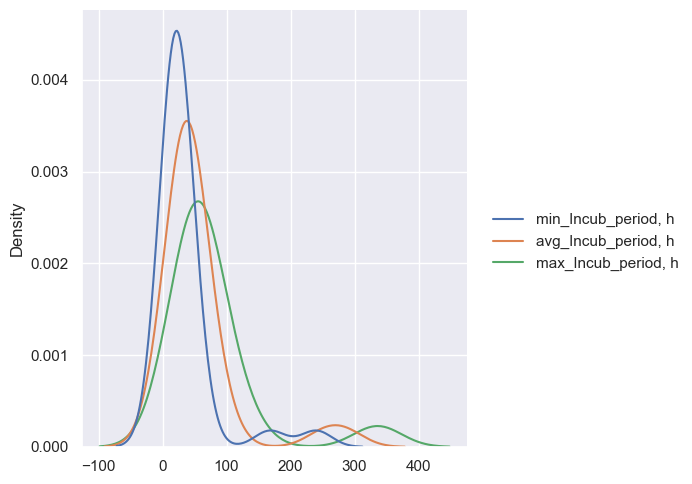

In [42]:
sns.displot(data=df_bac[['min_Incub_period, h', 'avg_Incub_period, h', 'max_Incub_period, h']], kind='kde')

In [43]:
df_bac[df_bac['min_Incub_period, h'].isna()]

,Bacteria,kingdom,phylum,class,order,family,genus,species,gram,"min_Incub_period, h","avg_Incub_period, h","max_Incub_period, h","growth_temp, C",biosafety_level,isolated_from
Tax_id,,,,,,,,,,,,,,,
['618'],Serratia odorifera,Bacteria,Pseudomonadota,Gammaproteobacteria,Enterobacterales,Yersiniaceae,Serratia,Serratia odorifera,n,NaN,0.0,NaN,30,1,soil


In [44]:
df_bac.loc[df_bac['min_Incub_period, h'].isna(), 'min_Incub_period, h'] = df_bac['min_Incub_period, h'].mode()[0]
df_bac.loc[df_bac['max_Incub_period, h'].isna(), 'max_Incub_period, h'] = df_bac['max_Incub_period, h'].mode()[0]
df_bac.loc[df_bac['avg_Incub_period, h'].isna(), 'avg_Incub_period, h'] = df_bac['avg_Incub_period, h'].mode()[0]

## Думаем над фичами

1. Три коррелирующих числа (min max и avg время инкубации) нам ни к чему, но можно посчитать "размах" - вдруг он окажется полезным

In [45]:
df_bac['min_max_Incub_period'] = df_bac['max_Incub_period, h'] - df_bac['min_Incub_period, h']
df_bac.drop(columns=['max_Incub_period, h', 'min_Incub_period, h'], inplace=True)
df_bac = df_bac.rename(columns={'avg_Incub_period, h': 'avg_Incub_period'})

Обнаружилась корреляция ```min_max_Incub_period``` с ```avg_Incub_period```, но график выглядит не так уж страшно линейным, поэтому попробуем.

<Axes: >

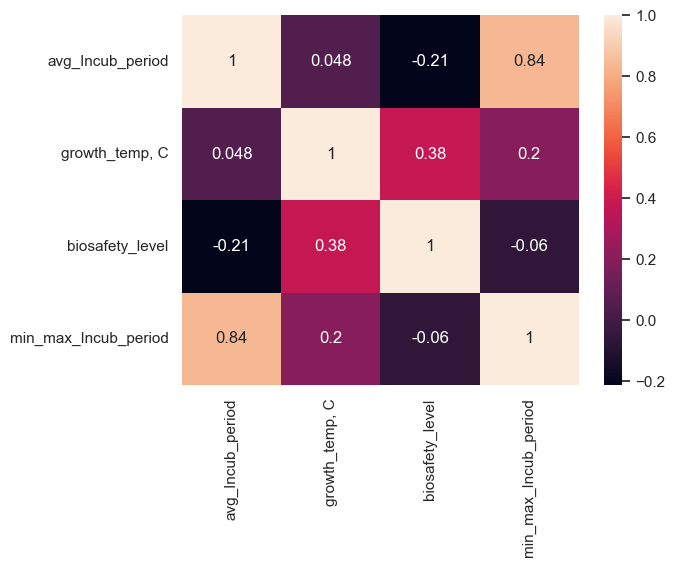

In [46]:
sns.heatmap(df_bac.corr(numeric_only=True), annot=True)

размах имеет слишком большую кореляцию, придется выкинуть :(

In [47]:
df_bac.drop(columns=['min_max_Incub_period'], inplace=True)

# 6 | Слияние трех баз данных в одну

In [48]:
df.drop_duplicates(inplace=True)
print(df.shape)
df = df.merge(df_bac, on='Bacteria', how='left')
df = df.merge(df_drug, on='Drug', how='left')
df.drop_duplicates(inplace=True)
print(df.shape)

(577, 15)
(577, 37)


In [49]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 577 entries, 0 to 576
Data columns (total 37 columns):
 #   Column                                       Non-Null Count  Dtype  
---  ------                                       --------------  -----  
 0   Bacteria                                     577 non-null    object 
 1   NP_Synthesis                                 577 non-null    object 
 2   Drug                                         577 non-null    object 
 3   Drug_class_drug_bank                         577 non-null    object 
 4   NP_concentration                             577 non-null    object 
 5   avg_NP_size                                  577 non-null    float64
 6   shape                                        577 non-null    object 
 7   method                                       577 non-null    object 
 8   ZOI_drug                                     563 non-null    float64
 9   ZOI_drug_NP                                  577 non-null    float64
 10  fo